# Clipping vs Sampling in iDP-SGD

## Define Setup


In [134]:
## Load Imports

from opacus_new import PrivacyEngine
from opacus_new.accountants import RDPAccountant
from opacus_new.validators.module_validator import ModuleValidator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as models

import numpy as np
import seaborn as sns

from types import SimpleNamespace
from tqdm import tqdm
import pandas as pd
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Secure RNG turned off.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [135]:
## Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, num_samples=10_000, height=32, width=32, num_features=3, transform=None, target_transform=None):
        self.data = (255 * np.random.rand(num_samples, height, width, num_features)).astype(np.uint8)
        self.targets = torch.randint(0, 10, (num_samples,))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        # Apply transformations if any
        if self.transform:
            sample = self.transform(sample)

        if self.target_transform:
            target = self.target_transform(target)

        return sample, target
    
    @classmethod
    def from_dataset(cls, dataset):
        return cls(data=dataset.data,
                targets=dataset.targets,
                transform=dataset.transform,
                target_transform=dataset.target_transform)

In [136]:
## Define a custom model class

class DummyResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [137]:

def make_private(model, train_loader, pp_budgets, args):
    modulevalidator = ModuleValidator()
    model = modulevalidator.fix_and_validate(model)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    privacy_engine = PrivacyEngine(accountant=args.accountant,
                                   individualize=args.individualize,
                                   weights=args.weights,
                                   pp_budgets=pp_budgets)
    if args.adapt_weights_to_budgets:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private_with_epsilon(module=model,
                                       optimizer=optimizer,
                                       data_loader=train_loader,
                                       target_epsilon=min(pp_budgets),
                                       target_delta=args.target_delta,
                                       epochs=args.epochs,
                                       max_grad_norm=args.max_grad_norm,
                                       optimal=True,
                                       max_alpha=10_000)
                                    #    numeric=True)
    else:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private(module=model,
                          optimizer=optimizer,
                          data_loader=train_loader,
                          noise_multiplier=args.noise_multiplier,
                          max_grad_norm=args.max_grad_norm)

    if args.individualize == 'clipping':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": privacy_engine.weights,
            "sample_rate": [1 / len(private_loader)] * len(privacy_engine.weights),
            "noise_multiplier": [private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    elif args.individualize == 'sampling':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": [args.max_grad_norm] * len(privacy_engine.weights),
            "sample_rate":privacy_engine.weights,
            "noise_multiplier":[private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    else:
        return

In [138]:
def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    def compute_epsilon(noise_multiplier, delta, iterations, sampling_rate, clipping_norm):
        accountant = RDPAccountant()
        for _ in range(int(iterations)):
            accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
        return accountant.get_epsilon(delta)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = compute_epsilon(noise_multiplier, delta, iterations, sampling_rate, clipping_norm)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

## Define Experiment

In [139]:
import os
import json
import hashlib
import pickle

args = SimpleNamespace(
    accountant="rdp",  # Options: "rdp", "gdp", etc.
    individualize="clipping", # "sampling",  # Options: None, "clipping", "sampling"
    weights=None,  # Should be a list or None
    adapt_weights_to_budgets=True,  # Whether to adapt weights to budgets
    target_delta=1e-10,  # Default delta value for DP
    epochs=5,  # Number of training epochs
    max_grad_norm=1,  # Clipping norm for DP-SGD
    # noise_multiplier=1.0,  # Noise multiplier for DP
    n_data=2000,  # Number of data points
)
dummy_train_loader = DataLoader(CustomDataset(num_samples=args.n_data), batch_size=128, shuffle=True)
dummy_model = DummyResNet18()


overwrite = True
deltas = np.logspace(-5, -1, num=50)
privacy_group_1 = np.array([16, 50]) # np.linspace(3, 20, num=5)
privacy_group_2 = np.array([16, 50]) # np.linspace(3, 20, num=5)
portion_size_var = np.array([0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99])

## Log data and Load (if) existing data

In [140]:
## Load existing results if available

config = {
    "args": vars(args),
    "privacy_group_1": privacy_group_1.tolist(),
    "privacy_group_2": privacy_group_2.tolist(),
    "portion_size_var": portion_size_var.tolist(),
    "deltas": deltas.tolist()
}

# Generate a unique hash for the config
config_str = json.dumps(config, sort_keys=True)
config_hash = hashlib.md5(config_str.encode()).hexdigest()
folder_name = f"./experiments/experiment_{config_hash}"

# Create folder if it doesn't exist, else load data.pkl if present
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    config_path = os.path.join(folder_name, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=2)
    sampling_df = None
    clipping_df = None
else:
    config_path = os.path.join(folder_name, "config.json")
    sampling_df_path = os.path.join(folder_name, "sampling_df.pkl")
    clipping_df_path = os.path.join(folder_name, "clipping_df.pkl")
    if os.path.exists(sampling_df_path):
        with open(sampling_df_path, "rb") as f:
            sampling_df = pickle.load(f)
    else:
        sampling_df = None
    if os.path.exists(clipping_df_path):
        with open(clipping_df_path, "rb") as f:
            clipping_df = pickle.load(f)
    else:
        clipping_df = None



## Compute Epsilon - Delta curves

In [141]:
import concurrent.futures

from tqdm.notebook import tqdm as notebook_tqdm

sampling_results = []
clipping_results = []

def compute_task(privacy_fixed, privacy_var, portion, args, dummy_model, dummy_train_loader, deltas):
    import numpy as np  # Needed for worker processes
    results = []
    pp_budgets = [privacy_var] * int(portion * args.n_data) + [privacy_fixed] * int(args.n_data - int(portion * args.n_data))
    
    # args.individualize = 'clipping'
    # clipping_data = make_private(dummy_model, dummy_train_loader, pp_budgets, args)
    # clipping_data_noise_multiplier = clipping_data['noise_multiplier']
    # clipping_data_max_grad_norms = clipping_data['max_grad_norms']
    # clipping_data_sample_rate = clipping_data['sample_rate']

    args.individualize = 'sampling'
    sampling_data = make_private(dummy_model, dummy_train_loader, pp_budgets, args)
    sampling_data_noise_multiplier = sampling_data['noise_multiplier']
    sampling_data_max_grad_norms = sampling_data['max_grad_norms']
    sampling_data_sample_rate = sampling_data['sample_rate']

    # if len(clipping_data_noise_multiplier) == 1:
    #     clipping_data_noise_multiplier *= 2
    # if len(clipping_data_max_grad_norms) == 1:
    #     clipping_data_max_grad_norms *= 2
    # if len(clipping_data_sample_rate) == 1:
    #     clipping_data_sample_rate *= 2

    if len(sampling_data_noise_multiplier) == 1:
        sampling_data_noise_multiplier *= 2
    if len(sampling_data_max_grad_norms) == 1:
        sampling_data_max_grad_norms *= 2
    if len(sampling_data_sample_rate) == 1:
        sampling_data_sample_rate *= 2

    if privacy_fixed > privacy_var:
        var_index = 0
        fixed_index = 1
    else:
        var_index = 1
        fixed_index = 0

    for mode, data in [
        # ("clipping_var", (clipping_data_noise_multiplier[var_index], clipping_data_sample_rate[var_index], clipping_data_max_grad_norms[var_index])),
        # ("clipping_fixed", (clipping_data_noise_multiplier[fixed_index], clipping_data_sample_rate[fixed_index], clipping_data_max_grad_norms[fixed_index])),
        ("sampling_var", (sampling_data_noise_multiplier[var_index], sampling_data_sample_rate[var_index], sampling_data_max_grad_norms[var_index])),
        ("sampling_fixed", (sampling_data_noise_multiplier[fixed_index], sampling_data_sample_rate[fixed_index], sampling_data_max_grad_norms[fixed_index])),
    ]:  
        epsilons, deltas_out = compute_epsilon_delta(
            noise_multiplier=data[0],
            deltas=deltas,
            iterations=args.epochs * len(dummy_train_loader),
            sampling_rate=data[1],
            clipping_norm=data[2]
        )
        type_label = "var" if "var" in mode else "fixed"
        for eps, delta in zip(epsilons, deltas_out):
            results.append({
                'privacy_fixed': privacy_fixed,
                'privacy_var': privacy_var,
                'portion': portion,
                'type': type_label,
                'epsilon': eps,
                'delta': delta,
                'mode': mode
            })
    return results


if (sampling_df is None or clipping_df is None) or overwrite:
    tasks = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for privacy_fixed in notebook_tqdm(privacy_group_1, desc="privacy_fixed", position=0, leave=True, disable=False):
            for privacy_var in privacy_group_2:
                for portion in portion_size_var:
                    # Submit each task
                    tasks.append(executor.submit(
                        compute_task,
                        privacy_fixed, privacy_var, portion,
                        args, dummy_model, dummy_train_loader, deltas
                    ))

        for future in notebook_tqdm(concurrent.futures.as_completed(tasks), total=len(tasks), desc="Aggregating results"):
            try:
                result = future.result()
                print(result)
                for entry in result:
                    # print(f"Entry mode: {entry['mode']}")
                    if entry['mode'].startswith('clipping'):
                        clipping_results.append({k: v for k, v in entry.items() if k != 'mode'})
                    else:
                        sampling_results.append({k: v for k, v in entry.items() if k != 'mode'})
            except Exception as e:
                print(f"Task failed: {e}")

    sampling_df = pd.DataFrame(sampling_results)
    # clipping_df = pd.DataFrame(clipping_results)
    sampling_df.to_pickle(os.path.join(folder_name, "sampling_df.pkl"))
    # clipping_df.to_pickle(os.path.join(folder_name, "clipping_df.pkl"))
else:
    print("Already loaded existing results from disk.")

privacy_fixed:   0%|          | 0/2 [00:00<?, ?it/s]

Aggregating results:   0%|          | 0/28 [00:00<?, ?it/s]

[{'privacy_fixed': np.int64(16), 'privacy_var': np.int64(16), 'portion': np.float64(0.8), 'type': 'var', 'epsilon': 9.516776738820134, 'delta': np.float64(1e-05), 'mode': 'sampling_var'}, {'privacy_fixed': np.int64(16), 'privacy_var': np.int64(16), 'portion': np.float64(0.8), 'type': 'var', 'epsilon': 9.399297907544927, 'delta': np.float64(1.2067926406393289e-05), 'mode': 'sampling_var'}, {'privacy_fixed': np.int64(16), 'privacy_var': np.int64(16), 'portion': np.float64(0.8), 'type': 'var', 'epsilon': 9.28181907626972, 'delta': np.float64(1.4563484775012445e-05), 'mode': 'sampling_var'}, {'privacy_fixed': np.int64(16), 'privacy_var': np.int64(16), 'portion': np.float64(0.8), 'type': 'var', 'epsilon': 9.164340244994515, 'delta': np.float64(1.757510624854793e-05), 'mode': 'sampling_var'}, {'privacy_fixed': np.int64(16), 'privacy_var': np.int64(16), 'portion': np.float64(0.8), 'type': 'var', 'epsilon': 9.046861413719308, 'delta': np.float64(2.1209508879201926e-05), 'mode': 'sampling_var'}

In [142]:
print("Sampling DataFrame:")
print(sampling_df.head())

Sampling DataFrame:
   privacy_fixed  privacy_var  portion type   epsilon     delta
0             16           16      0.8  var  9.516777  0.000010
1             16           16      0.8  var  9.399298  0.000012
2             16           16      0.8  var  9.281819  0.000015
3             16           16      0.8  var  9.164340  0.000018
4             16           16      0.8  var  9.046861  0.000021


## Plots

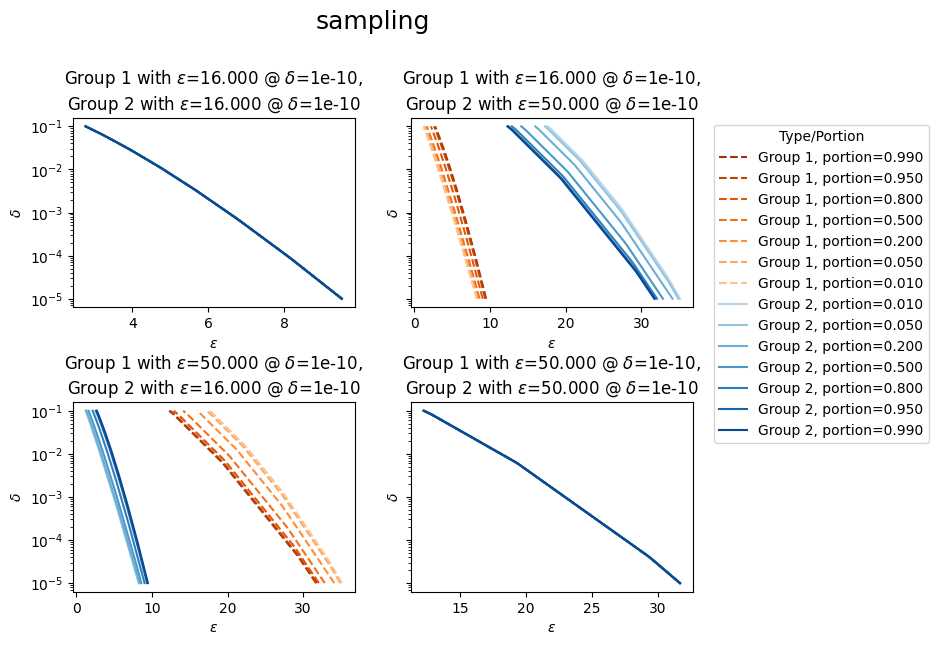

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_together(df, name_extension=""):
    unique_privacy_fixed = np.sort(df['privacy_fixed'].unique())
    unique_privacy_var = np.sort(df['privacy_var'].unique())
    unique_portion = np.sort(df['portion'].unique())

    n = len(unique_privacy_fixed)
    m = len(unique_privacy_var)

    # Define two base colors for "var" and "fixed"
    base_color_var = sns.color_palette("Blues", n_colors=len(unique_portion)+2)[2:]
    base_color_fixed = sns.color_palette("Oranges", n_colors=len(unique_portion)+2)[2:][::-1]

    # Plot separated by "type" (var/fixed)
    fig, axes = plt.subplots(n, m, figsize=(4*m, 3*n), sharex=False, sharey=True)
    for i, pf in enumerate(unique_privacy_fixed):
        for j, pv in enumerate(unique_privacy_var):
            ax = axes[i, j] if n > 1 and m > 1 else (axes[j] if n == 1 else axes[i])
            df_sub = df[(df['privacy_fixed'] == pf) & (df['privacy_var'] == pv)]
            for t, style in enumerate(['fixed', 'var']):
                color_list = base_color_var if style == 'var' else base_color_fixed
                for k, portion in enumerate(unique_portion):
                    df_line = df_sub[(df_sub['portion'] == portion) & (df_sub['type'] == style)]
                    portion_label = 1 - portion if style == "fixed" else portion
                    if not df_line.empty:
                        df_line = df_line.sort_values('delta')
                        # Swap x and y: x='epsilon', y='delta'
                        if not (style == 'var' and portion == 0.0):
                            ax.plot(df_line['epsilon'], df_line['delta'],
                                    label=f'{"Group 1" if style=="fixed" else "Group 2"}, portion={portion_label:.3f}',
                                    color=color_list[k], linestyle='-' if style == 'var' else '--')
            # Add horizontal line at args.target_delta (now y-axis)
            # ax.axhline(args.target_delta, color='red', linestyle=':', label='target_delta' if (i == 0 and j == 0) else None)
            ax.set_yscale('log')
            ax.set_xlabel(r'$\epsilon$')
            ax.set_ylabel(r'$\delta$')
            ax.set_title(f'Group 1 with $\epsilon$={pf:.3f} @ $\delta$={args.target_delta},\nGroup 2 with $\epsilon$={pv:.3f} @ $\delta$={args.target_delta}')
            if i == 0 and j == m-1:
                ax.legend(title='Type/Portion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle(str(name_extension), fontsize=18)
    plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.5, wspace=0.2)
    plt.show()
    # Save the figure with extra space for the legend
    fig.savefig(f"{folder_name}/combined_{name_extension}.png", bbox_inches='tight')

plot_together(sampling_df, "sampling")
# plot_together(clipping_df, "clipping")

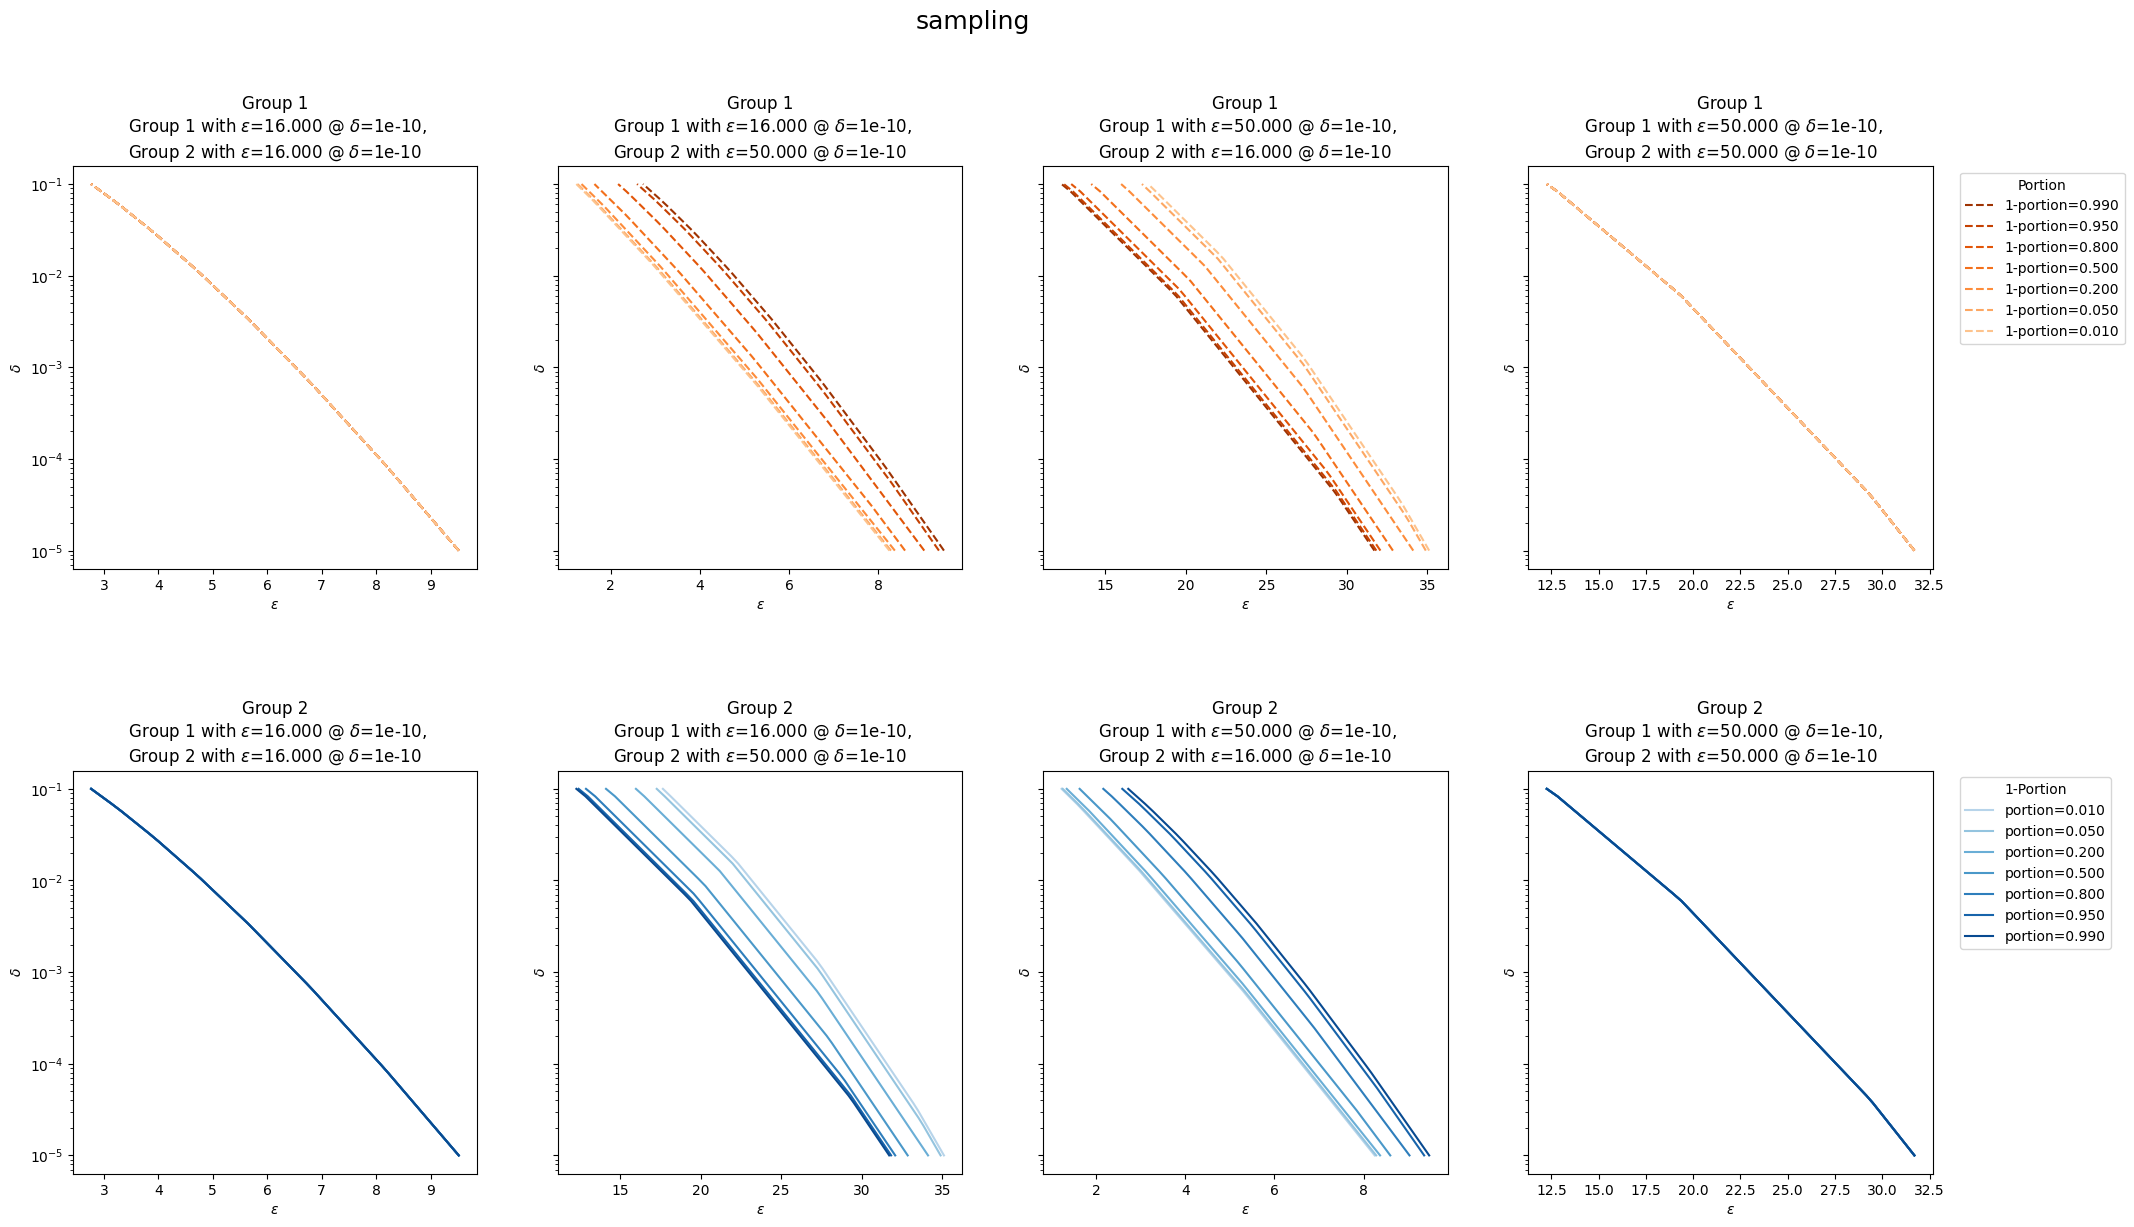

TypeError: 'NoneType' object is not subscriptable

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_separate(df, name_extension=""):
    # Get unique values for grid dimensions
    unique_privacy_fixed = np.sort(df['privacy_fixed'].unique())
    unique_privacy_var = np.sort(df['privacy_var'].unique())
    unique_portion = np.sort(df['portion'].unique())

    n = len(unique_privacy_fixed)
    m = len(unique_privacy_var)
    n_panels = n * m

    # Calculate grid shape to be as square as possible
    ncols = math.ceil(n_panels)
    nrows = math.ceil(2)

    # Define two base colors for "var" and "fixed"
    base_color_var = sns.color_palette("Blues", n_colors=len(unique_portion)+2)[2:]
    base_color_fixed = sns.color_palette("Oranges", n_colors=len(unique_portion)+2)[2:][::-1]

    # Create a 2-row grid: row 0 for 'var', row 1 for 'fixed'
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows), sharex=False, sharey=True)

    for row, style in enumerate(['fixed', 'var']):
        color_list = base_color_var if style == 'var' else base_color_fixed
        for i, pf in enumerate(unique_privacy_fixed):
            for jdx, pv in enumerate(unique_privacy_var):
                ax_idx = i * m + jdx
                ax = axes[row, ax_idx]
                df_sub = df[(df['privacy_fixed'] == pf) & (df['privacy_var'] == pv) & (df['type'] == style)]
                for k, portion in enumerate(unique_portion):
                    df_line = df_sub[(df_sub['portion'] == portion)]
                    if not df_line.empty:
                        df_line = df_line.sort_values('delta')
                        label = (f'portion={portion:.3f}' if style == 'var'
                                else f'1-portion={1-portion:.3f}')
                        # Swap x and y: x='epsilon', y='delta'
                        if not (style == 'var' and portion == 0.0):
                            ax.plot(df_line['epsilon'], df_line['delta'],
                                    label=label,
                                    color=color_list[k], linestyle='-' if style == 'var' else '--')
                # Add horizontal line at args.target_delta (now y-axis)
                # ax.axhline(args.target_delta, color='red', linestyle=':', label='target_delta' if (row == 0 and ax_idx == 0) else None)
                ax.set_yscale('log')
                ax.set_ylabel(r'$\delta$')
                ax.set_xlabel(r'$\epsilon$')
                ax.set_title(f'{"Group 1" if style=="fixed" else "Group 2"}\n Group 1 with $\epsilon$={pf:.3f} @ $\delta$={args.target_delta},\nGroup 2 with $\epsilon$={pv:.3f} @ $\delta$={args.target_delta}')
                if row == 0 and ax_idx == n_panels-1:
                    ax.legend(title='Portion', bbox_to_anchor=(1.05, 1), loc='upper left')
                if row == 1 and ax_idx == n_panels-1:
                    ax.legend(title='1-Portion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle(str(name_extension), fontsize=18)
    plt.subplots_adjust(top = 0.85, bottom=0.01, hspace=0.5, wspace=0.2)
    plt.show()
    fig.savefig(f"{folder_name}/separate_{name_extension}.png", bbox_inches='tight')

plot_separate(sampling_df, "sampling")
plot_separate(clipping_df, "clipping")
